In [1]:
import math

import librosa
import pandas
import numpy

from matplotlib import pyplot as plt
import librosa.display


In [481]:

samplerate = 16000
time_resolution = 0.10

def next_power_of_2(x):
    return 2**(math.ceil(math.log(x, 2)))

hop_length = int(time_resolution*samplerate)
n_fft = next_power_of_2(hop_length)

print(hop_length, n_fft)

1600 2048


In [482]:
def load_annotations(path):
    df = pandas.read_csv(path, header=None)
    df.columns = ['start', 'end', 'event']
    
    # drop duplicates
    df = df[~df['start'].duplicated()]
    
    df['duration'] = df['end'] - df['start']
    df = df.sort_values('start')
    
    return df

annotations_path = 'data/annotations.csv'
annotations = load_annotations(annotations_path)
annotations.head(1)

,start,end,event,duration
0,7.055938,7.220668,yes,0.16473


In [483]:
annotations.tail(1)

,start,end,event,duration
124,299.328251,299.438071,yes,0.10982


In [484]:
annotations.event.value_counts()

yes    120
Name: event, dtype: int64

<AxesSubplot:>

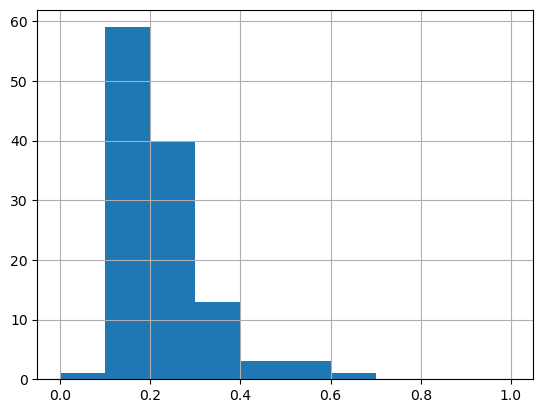

In [485]:
annotations.duration.hist(width=0.10, range=(0, 1.0))

<AxesSubplot:>

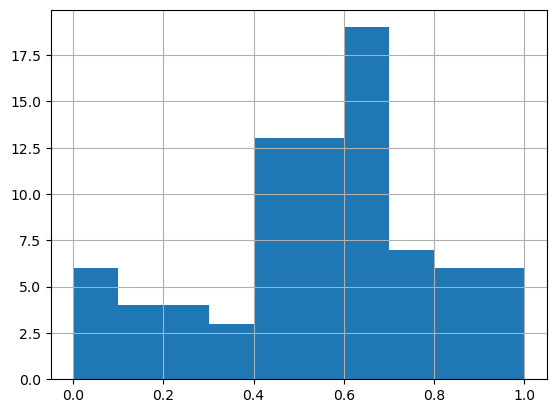

In [486]:
(annotations['start'] - (annotations['end'].shift(1))).hist(width=0.1, range=(0, 1.0))


In [487]:
def load_spectrogram(path, sr=16000, n_mels=32, n_fft=1024, hop_length=512):
    y, sr = librosa.load(path, sr=sr)
    
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, n_mels=n_mels, hop_length=hop_length)
    db = librosa.power_to_db(S, ref=0.0)
    
    return db

audio_path = 'data/source2.wav'
spec = load_spectrogram(audio_path, hop_length=hop_length, n_fft=n_fft)
spec.shape

(32, 3001)

In [488]:
def spectrogram_labels(events, spec, time_resolution):
    """
    Create a continious vector for the event labels that matches the time format of our spectrogram
    
    Assumes that no annotated event means nothing occurred.
    """

    freq = pandas.Timedelta(seconds=time_resolution)
    
    # Create empty covering entire spectrogram
    spec_duration = spec.shape[1] * time_resolution
    ix = pandas.timedelta_range(start=pandas.Timedelta(seconds=0.0),
                    end=pandas.Timedelta(seconds=spec_duration),
                    freq=freq,
                    closed='left',
    )
    ix.name = 'time'
    df = pandas.DataFrame({}, index=ix)
    assert len(df) == spec.shape[1], (len(df), spec.shape[1])
    df["event"] = 0
    
    # fill in event data
    for start, end in zip(events['start'], events['end']):
        s = pandas.Timedelta(start, unit='s')
        e = pandas.Timedelta(end, unit='s')
        #
        e = s + pandas.Timedelta(0.100, unit='s') # XXX: trying to focus just on onsets
        match = df.loc[s:e]
        df.loc[s:e, "event"] = 1
    
    return df

l = spectrogram_labels(annotations[annotations.event == 'yes'], spec, time_resolution)
l.event.value_counts()

0    2881
1     120
Name: event, dtype: int64

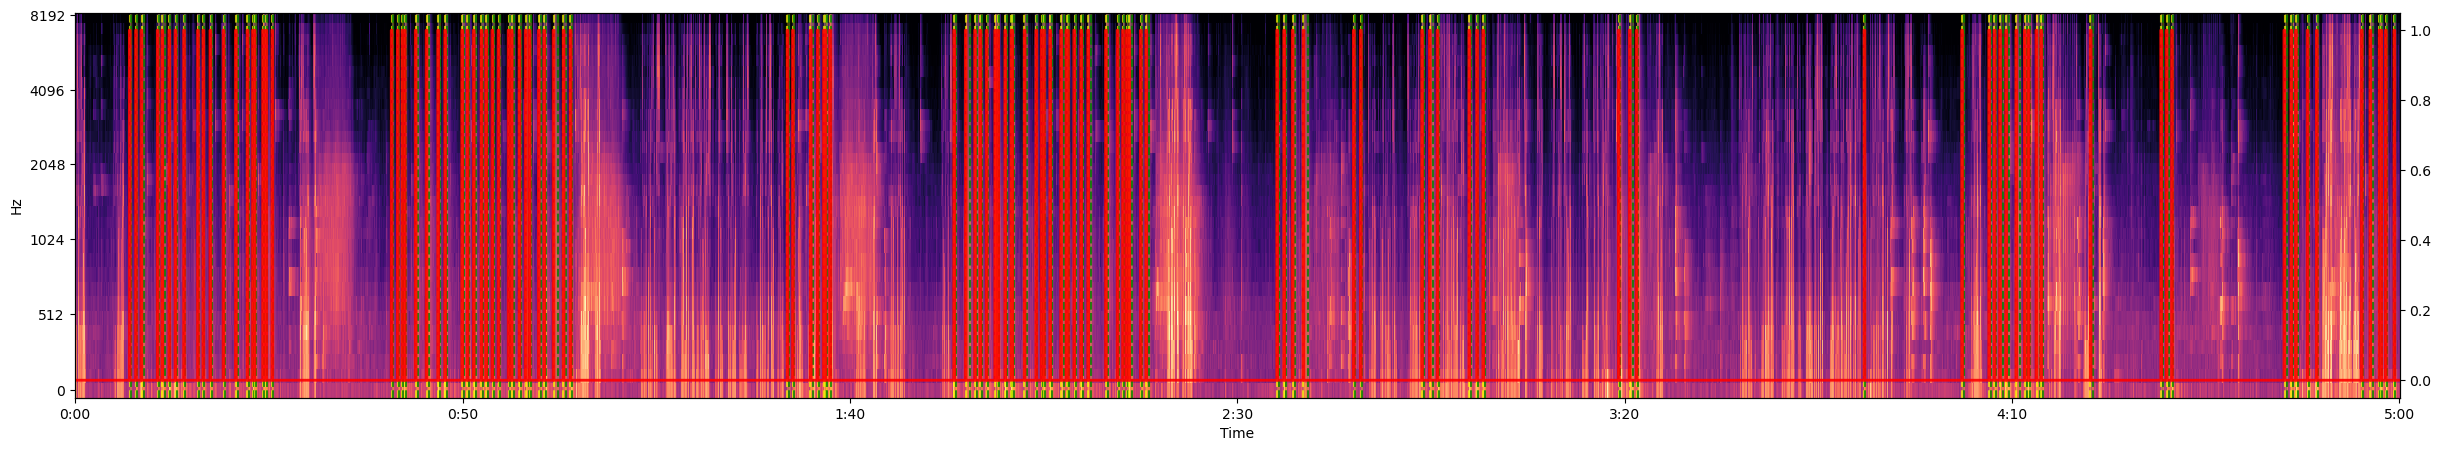

In [489]:
def soundlevel_spectrogram(spec):
    n_mels = spec.shape[0]
    
    freqs = librosa.mel_frequencies(n_mels=n_mels, fmin=0.001, fmax=samplerate/2.)
    weights = librosa.A_weighting(freqs)
    weighted = spec - numpy.expand_dims(weights, axis=-1)
    
    #energy = librosa.db_to_power(weighted)
    #s = librosa.power_to_db(energy.sum(axis=0) / n_mels)
    s = weighted.mean(axis=0)
    return s
    
    
def plot_spectrogram(ax, spec, events=None, label_activations=None, predictions=None, plot_soundlevels=None):
    events_lw = 1.5
    
    # Plot spectrogram
    librosa.display.specshow(ax=ax, data=spec, hop_length=hop_length, x_axis='time', y_axis='mel', sr=samplerate)

    # Plot events
    if events is not None:
        for start, end in zip(events.start, events.end):
            ax.axvspan(start, end, alpha=0.2, color='yellow')
            ax.axvline(start, alpha=0.7, color='yellow', ls='--', lw=events_lw)
            ax.axvline(end, alpha=0.8, color='green', ls='--', lw=events_lw)

    label_ax = ax.twinx()
    
    # Plot soundlevel
    if plot_soundlevels:
        sl = soundlevel_spectrogram(spec)
        sl_norm = sl / numpy.max(sl)
        t = librosa.frames_to_time(numpy.arange(spec.shape[1]), hop_length=hop_length, sr=samplerate)
        label_ax.plot(t, sl_norm)
    
    # Plot event activations
    if label_activations is not None:
        a = label_activations.reset_index()
        a['time'] = a['time'].dt.total_seconds()
        label_ax.step(a['time'], a['event'], color='red', alpha=0.9, lw=2.0)

    # Plot model predictions
    if predictions is not None:
        p = predictions.reset_index()
        p['time'] = p['time'].dt.total_seconds()
        label_ax.step(p['time'], p['probability'], color='blue', alpha=0.9, lw=3.0)
            
        label_ax.axhline(0.5, ls='--', color='black', alpha=0.5, lw=2.0)
            
fig, ax = plt.subplots(1, figsize=(30, 5))
plot_spectrogram(ax, spec, annotations, l)
#ax.set_xlim(10, 15)

(0.0, 15.0)

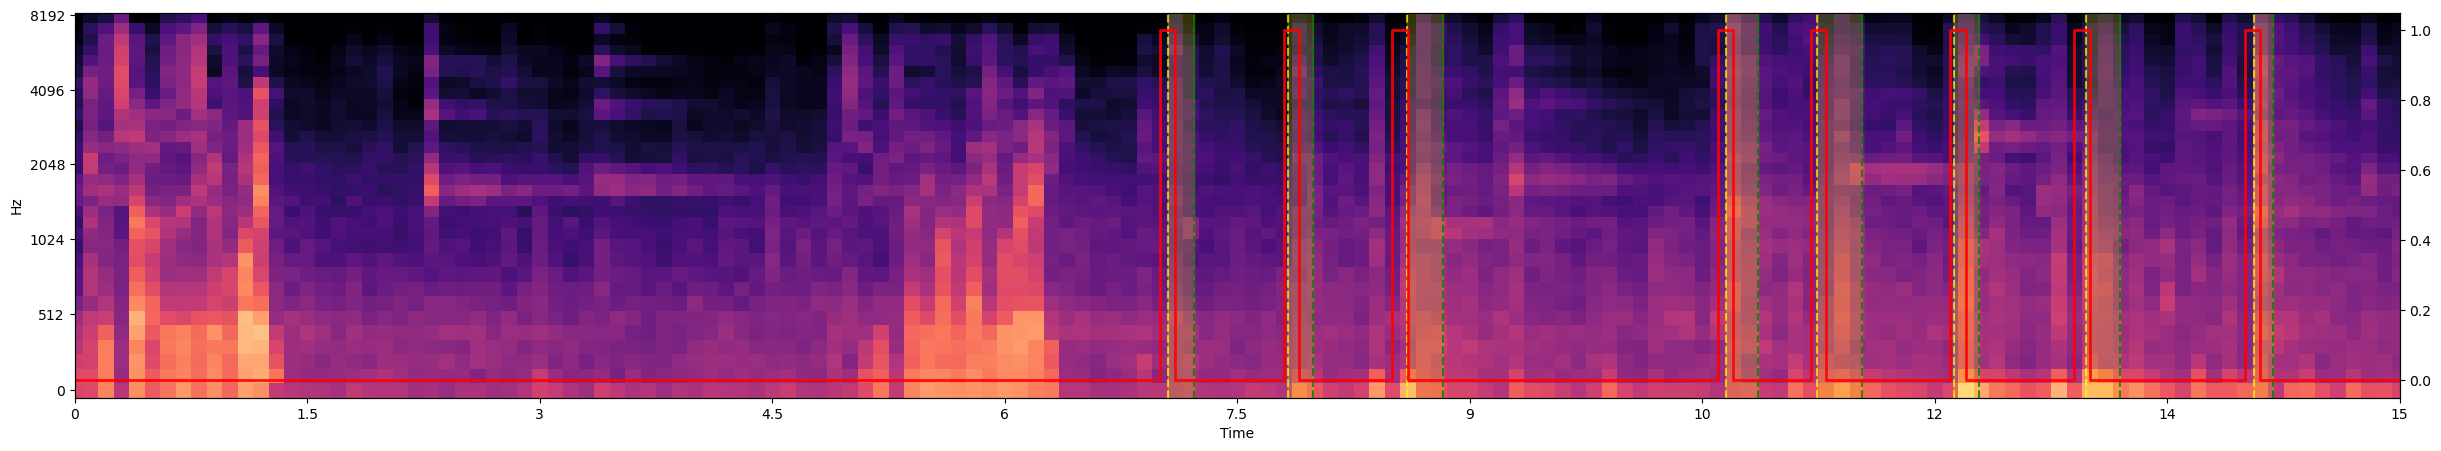

In [490]:
fig, ax = plt.subplots(1, figsize=(30, 5))
plot_spectrogram(ax, spec, annotations, l)
ax.set_xlim(0, 15)
#ax.set_xlim(110, 120)

(15.0, 30.0)

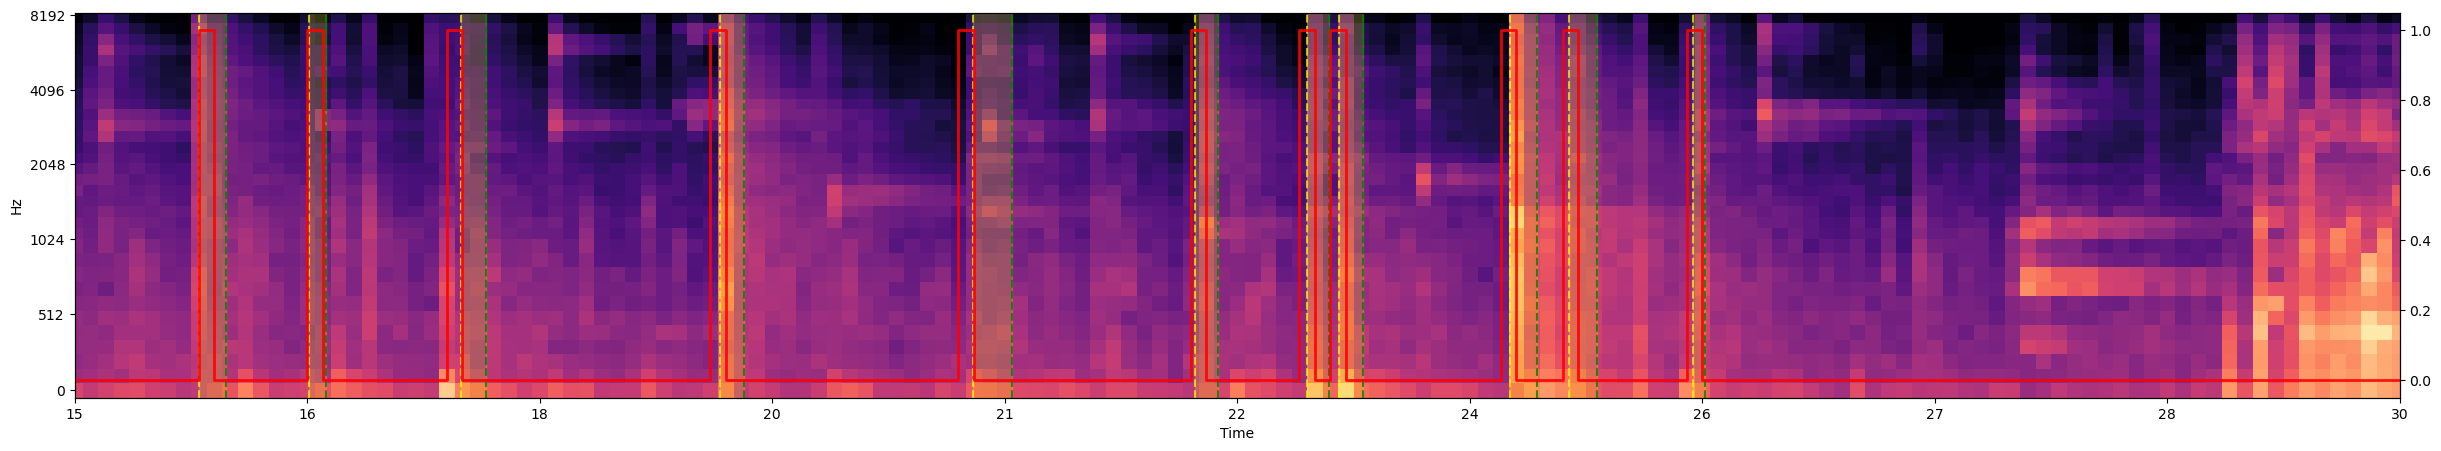

In [491]:
fig, ax = plt.subplots(1, figsize=(30, 5))
plot_spectrogram(ax, spec, annotations, l)
ax.set_xlim(15, 30)


In [520]:
window_duration = 0.801
window_length = int(window_duration / time_resolution)
window_length

8

In [521]:
# extract time-windows for spectrograms and labels

def compute_windows(arr, frames, pad_value=0.0, overlap=0.5, step=None):
    if step is None:
        step = int(frames * (1-overlap))
        
    windows = []
    
    width, length = arr.shape
    
    for start_idx in range(0, length, step):
        end_idx = min(start_idx + frames, length)

        # create emmpty
        win = numpy.full((width, frames), pad_value, dtype=float)
        # fill with data
        win[:, 0:end_idx-start_idx] = arr[:,start_idx:end_idx]

        windows.append(win)

    return windows

windows = pandas.DataFrame({
    'spectrogram': compute_windows(spec, frames=window_length, overlap=0.8),
    'labels': compute_windows(l.values.T, frames=window_length, overlap=0.8),
})
windows.shape

(3001, 2)

In [522]:

def compute_features(spec):
    sl = soundlevel_spectrogram(spec)
    sl_diff = numpy.diff(sl, n=1)
    f = pandas.Series({
        'db_max': sl.max(),
        'db_diff_max': sl_diff.max(),
        'db_rel_max': sl.max() - numpy.min(sl),
    })
    return f
    

ff = windows.spectrogram.apply(compute_features)
ff = pandas.merge(ff, windows, right_index=True, left_index=True)
ff['event'] = ff.labels.apply(lambda labels: numpy.any(labels, axis=-1)).astype(int)
ff.head()

,db_max,db_diff_max,db_rel_max,spectrogram,labels,event
0,85.9147,12.869550,21.599347,"[[87.59998321533203, 88.442138671875, 99.92037...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]",0
1,85.9147,7.455869,8.794445,"[[88.442138671875, 99.92037200927734, 80.75524...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]",0
2,85.9147,7.455869,8.794445,"[[99.92037200927734, 80.7552490234375, 101.805...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]",0
3,85.9147,7.455869,9.505554,"[[80.7552490234375, 101.8051528930664, 92.6839...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]",0
4,85.9147,6.310029,9.505554,"[[101.8051528930664, 92.68392944335938, 97.480...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]",0


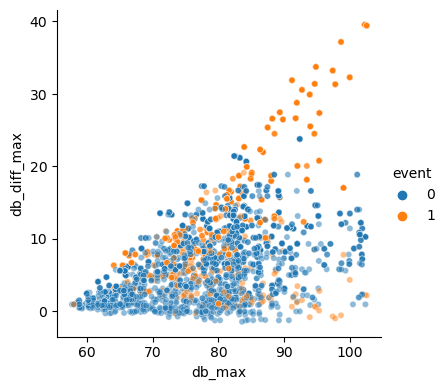

In [523]:
import seaborn
seaborn.relplot(data=ff,
                x='db_max',
                y='db_diff_max',
                hue='event',
                #col='event',
                s=20,
                height=4,
                aspect=1,
                alpha=0.5,
               ) 

""


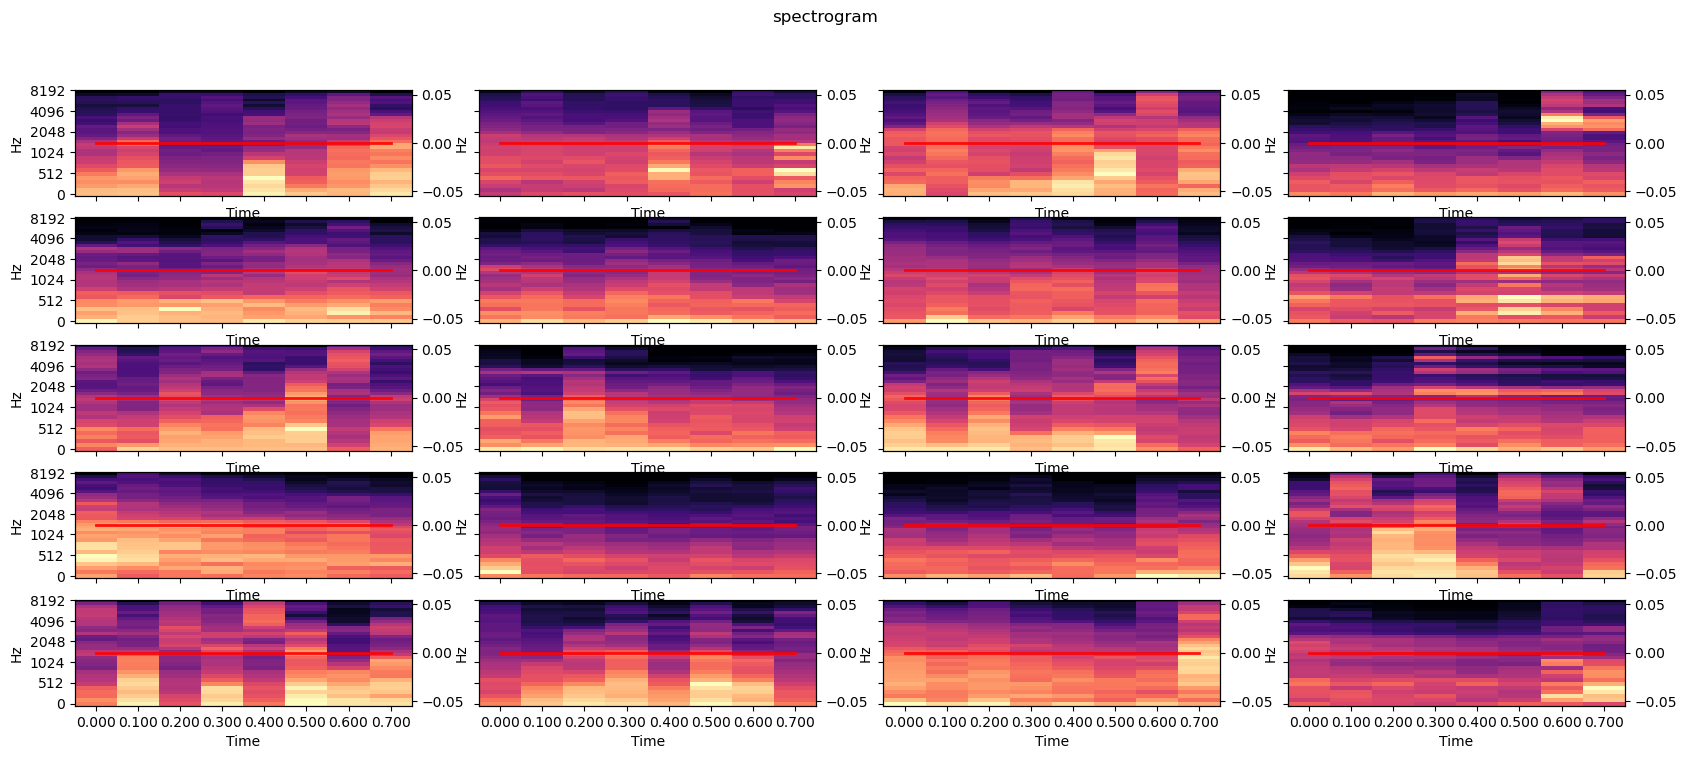

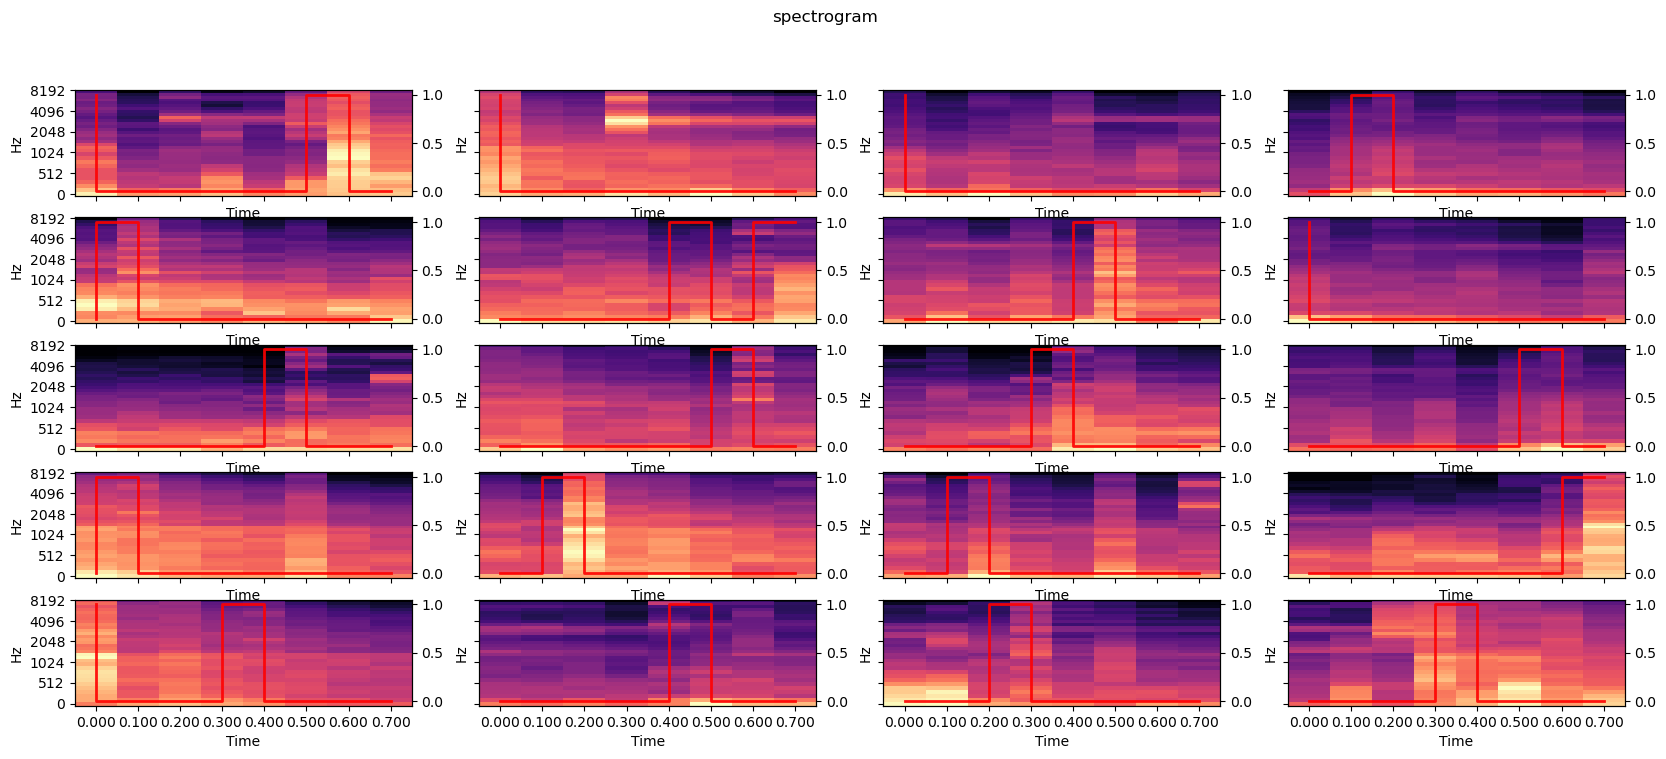

In [524]:
def plot_windows(wins, col_wrap=None, height=4, aspect=1):
    specs = wins.spectrogram
    
    nrow = 1
    ncol = len(specs)
    if col_wrap is not None:
        nrow = int(numpy.ceil(ncol / col_wrap))
        ncol = col_wrap

    fig_height = height * nrow
    fig_width = height * aspect * ncol
    fig, axs = plt.subplots(ncol, nrow, sharex=True, sharey=True, figsize=(fig_width, fig_height))
    axs = numpy.array(axs).flatten()
    
    fig.suptitle(specs.name)
    for ax, s, l in zip(axs, specs, wins.labels):
    
        l = numpy.squeeze(l)
        ll = pandas.DataFrame({
            'event': l,
            'time': pandas.to_timedelta(numpy.arange(l.shape[0])*hop_length/samplerate, unit='s'),
        })

        plot_spectrogram(ax, s, label_activations=ll)


ff.groupby('event').sample(n=20).groupby('event').apply(plot_windows, col_wrap=5, aspect=2, height=2)

In [525]:
# split windows into train, val, test
# note: random splitting has data leak. Much better to split by match!

def dataset_split_sequentially(data, val_size=0.25, test_size=0.25, random_state=3, column='split'):
    """
    Split DataFrame into 3 non-overlapping parts: train,val,test
    with specified proportions
    
    Returns a new DataFrame with the rows marked by the assigned split in @column
    """
    train_size = (1.0 - val_size - test_size)

    train_stop = int(len(data) * train_size)
    val_stop = train_stop + int(len(data)*val_size)
    
    train_idx = data.index[0:train_stop]
    val_idx = data.index[train_stop:val_stop]
    test_idx = data.index[val_stop:-1]
    
    data = data.copy()
    data.loc[train_idx, column] = 'train'
    data.loc[val_idx, column] = 'val'
    data.loc[test_idx, column] = 'test'
    
    return data

dataset = dataset_split_sequentially(windows, val_size=0.15, test_size=0.15)
dataset.split.value_counts()

train    2100
val       450
test      450
Name: split, dtype: int64

In [533]:
# build simple CNN model

import tensorflow.keras


def build_sednet(input_shape, filters=128, cnn_pooling=(5, 2, 2), rnn_units=(32, 32), dense_units=(32,), n_classes=1, dropout=0.5):
    """
    SEDnet type model
    
    Reference:
    Sharath Adavanne, Pasi Pertila and Tuomas Virtanen
    "Sound event detection using spatial features and convolutional recurrent neural network"
    IEEE International Conference on Acoustics, Speech and Signal Processing
    (ICASSP 2017)
    
    Based https://github.com/sharathadavanne/sed-crnn/blob/master/sed.py
    """
    
    from tensorflow.keras import Model
    from tensorflow.keras.layers import Input, Bidirectional, Conv2D, BatchNormalization, Activation, \
            Dense, MaxPooling2D, Dropout, Permute, Reshape, GRU, TimeDistributed
    
    spec_start = Input(shape=(input_shape[-3], input_shape[-2], input_shape[-1]))
    spec_x = spec_start
    for i, pool in enumerate(cnn_pooling):
        spec_x = Conv2D(filters=filters, kernel_size=(3, 3), padding='same')(spec_x)
        spec_x = BatchNormalization(axis=1)(spec_x)
        spec_x = Activation('relu')(spec_x)
        spec_x = MaxPooling2D(pool_size=(1, pool))(spec_x)
        spec_x = Dropout(dropout)(spec_x)
    spec_x = Permute((2, 1, 3))(spec_x)
    spec_x = Reshape((input_shape[-2], -1))(spec_x)

    for units in rnn_units:
        spec_x = Bidirectional(
            GRU(units, activation='tanh', dropout=dropout, recurrent_dropout=dropout, return_sequences=True),
            merge_mode='mul')(spec_x)

    for units in dense_units:
        spec_x = TimeDistributed(Dense(units))(spec_x)
        spec_x = Dropout(dropout)(spec_x)

    spec_x = TimeDistributed(Dense(n_classes))(spec_x)
    out = Activation('sigmoid', name='strong_out')(spec_x)
    
    model = Model(inputs=spec_start, outputs=out)
    
    return model
    

def weighted_binary_crossentropy(zero_weight, one_weight):
    import tensorflow.keras.backend as K
    
    def weighted_binary_crossentropy(y_true, y_pred):

        b_ce = K.binary_crossentropy(y_true, y_pred)

        # weighted calc
        weight_vector = y_true * one_weight + (1 - y_true) * zero_weight
        weighted_b_ce = weight_vector * b_ce

        return K.mean(weighted_b_ce)

    return weighted_binary_crossentropy

    
def make_weighted_loss(weights=[]):
    import tensorflow as tf
    c = tf.constant(weights)
    
    # TODO: fix this
    def innerLoss(true, pred):
        w = tf.gather(c) #(batch, labels, 1)
        #w = tf.reshape(w, (-1,labels)) #(batch, labels)

        #loss = tf.keras.backend.sparse_categorical_crossentropy(true, pred) #(batch, labels)
        loss = tf.keras.backend.binary_crossentropy(true, pred) #(batch, labels)
        loss = w * loss

        return loss

    return innerLoss
    
def build_model(input_shape, dropout=0.5, lr=0.01, class_weights=None):
    
    from tensorflow.keras.layers import Convolution2D, SeparableConv2D, GlobalMaxPooling2D, Flatten, Dense, Activation, Dropout
    
    model = build_sednet(input_shape, n_classes=1, filters=16, cnn_pooling=[2, 2], rnn_units=[5, 5], dense_units=[8], dropout=dropout)

    pr_auc = tensorflow.keras.metrics.AUC(num_thresholds=200, curve="PR", name='pr_auc')
    precision = tensorflow.keras.metrics.Precision(name='precision')
    recall = tensorflow.keras.metrics.Recall(name='recall')
    
    if class_weights is None:
        loss = tensorflow.keras.losses.BinaryCrossentropy()
    else:
        #loss = make_weighted_loss(class_weights)
        loss = weighted_binary_crossentropy(*class_weights)

    # Focal loss tends to be a bit better for imbalanced data
    #loss = tensorflow.keras.losses.BinaryFocalCrossentropy()
        
    model.compile(optimizer=tensorflow.keras.optimizers.SGD(learning_rate=lr),
                  loss=loss,
                  metrics=[pr_auc, precision, recall],
    )
    return model

model = build_model(input_shape=(32, window_length, 1), class_weights=class_weights)
model.summary()

Model: "model_64"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_78 (InputLayer)       [(None, 32, 8, 1)]        0         
                                                                 
 conv2d_175 (Conv2D)         (None, 32, 8, 16)         160       
                                                                 
 batch_normalization_149 (Ba  (None, 32, 8, 16)        128       
 tchNormalization)                                               
                                                                 
 activation_227 (Activation)  (None, 32, 8, 16)        0         
                                                                 
 max_pooling2d_148 (MaxPooli  (None, 32, 4, 16)        0         
 ng2D)                                                           
                                                                 
 dropout_297 (Dropout)       (None, 32, 4, 16)         0  

In [534]:

epochs = 400
batch_size = 2*64

Xm = numpy.expand_dims(numpy.mean(numpy.concatenate([s.T for s in dataset.spectrogram]), axis=0), -1)
print(Xm.shape)

def get_XY(split):
    d = dataset[dataset.split == split]
    X = numpy.expand_dims(numpy.stack([s-Xm for s in d.spectrogram]), -1)
    
    # spectral subtraction
    
    Y = numpy.stack([ l.T for l in d.labels], axis=0)    
    return X, Y

train = get_XY(split='train')
val = get_XY(split='val')



early_stop = tensorflow.keras.callbacks.EarlyStopping(monitor='val_pr_auc', patience=20)

def compute_class_weights(y_train):
    from sklearn.utils import class_weight
    y_train = numpy.squeeze(y_train).astype(int)
    y_train = numpy.any(y_train, axis=1)
    #print("ss", y_train.shape)
    w = class_weight.compute_class_weight('balanced', classes=numpy.unique(y_train), y=y_train)
    w_dict = dict(zip(numpy.unique(y_train), w))
    return w

class_weights = compute_class_weights(train[1])
print(class_weights)
#class_weights = None

model = build_model(input_shape=(32, window_length, 1), dropout=0.1, lr=1*0.1, class_weights=class_weights)
hist = model.fit(x=train[0], y=train[1],
        validation_data=val,
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stop],
        #class_weight=class_weights,
)


(32, 1)
[0.73684211 1.55555556]
Epoch 1/400
17/17 [==============================] - 5s 58ms/step - loss: 0.3964 - pr_auc: 0.0443 - precision: 0.0315 - recall: 0.0133 - val_loss: 0.2414 - val_pr_auc: 0.0350 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/400
17/17 [==============================] - 0s 21ms/step - loss: 0.2698 - pr_auc: 0.0480 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.1772 - val_pr_auc: 0.0428 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/400
17/17 [==============================] - 0s 21ms/step - loss: 0.2432 - pr_auc: 0.0467 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.1611 - val_pr_auc: 0.0435 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/400
17/17 [==============================] - 0s 21ms/step - loss: 0.2361 - pr_auc: 0.0508 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.1557 - val_pr_auc: 0.0514 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/400
17/17 [=============

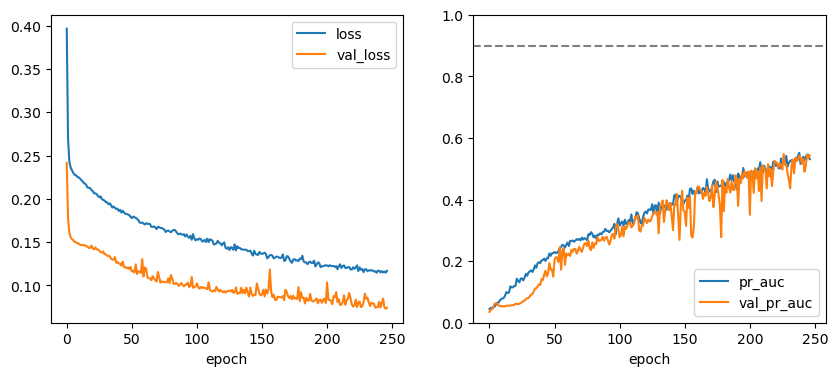

In [535]:
# Plot the scores over epochs
def plot_history(history):

    fig, axs = plt.subplots(ncols=2, figsize=(10, 4))
    history = pandas.DataFrame(hist.history)
    history.index.name = 'epoch'
    history.plot(ax=axs[0], y=['loss', 'val_loss'])
    history.plot(ax=axs[1], y=['pr_auc', 'val_pr_auc'])
    axs[1].set_ylim(0, 1.0)
    axs[1].axhline(0.9, ls='--', color='black', alpha=0.5)

    
plot_history(history)

In [536]:
class_weights

array([0.73684211, 1.55555556])

In [538]:
test = get_XY(split='test')

results = pandas.DataFrame({
    'split': [ 'test', 'train', 'val' ],
})
def get_metric(split):
    X, Y = get_XY(split=split)
    r = model.evaluate(x=X, y=Y, return_dict=True)
    return pandas.Series(r)

e = results.split.apply(get_metric)
results = pandas.merge(results, e, right_index=True, left_index=True).set_index('split')
results


15/15 [==============================] - 0s 4ms/step - loss: 0.0743 - pr_auc: 0.5431 - precision: 0.5915 - recall: 0.4773       


,loss,pr_auc,precision,recall
split,,,,
test,0.120192,0.387265,0.396040,0.333333
train,0.095719,0.661861,0.652632,0.577128
val,0.074281,0.543143,0.591549,0.477273


15/15 [==============================] - 1s 3ms/step
(450, 8)
(450, 8)
66/66 [==============================] - 0s 3ms/step
(2100, 8)
(2100, 8)
15/15 [==============================] - 0s 3ms/step
(450, 8)
(450, 8)


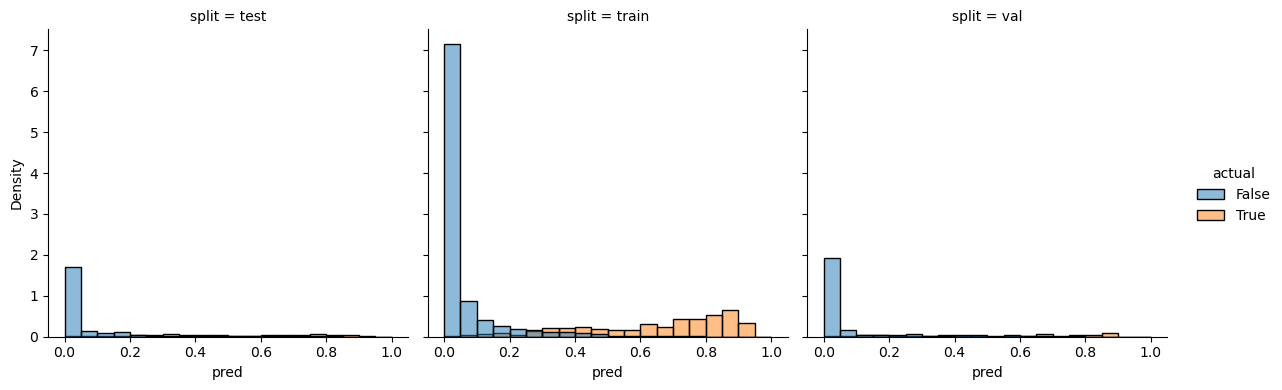

In [539]:
%matplotlib inline

import seaborn

rr = []
for split in results.reset_index().split.unique():
    X, Y = get_XY(split)
    
    y_true = numpy.squeeze(Y)
    y_pred = numpy.squeeze(model.predict(X))

    print(y_pred.shape)
    print(y_true.shape)
    
    r = pandas.DataFrame({
        'pred': numpy.max(y_pred, axis=1),
        'actual': numpy.any(y_true, axis=1),
        'split': split,
    })
    rr.append(r)

r = pandas.concat(rr, ignore_index=True)
seaborn.displot(kind='hist', data=r, x='pred', hue='actual', col='split', height=4, aspect=1, binrange=(0.0, 1.0), stat='density', binwidth=0.05)
    

15/15 [==============================] - 0s 3ms/step


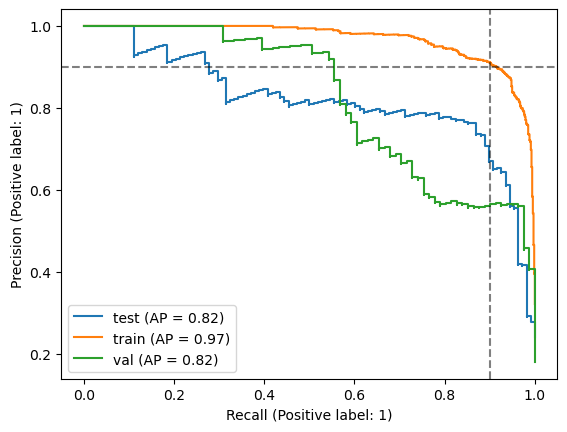

In [543]:
# Plot precision/recall trade-off

from sklearn.metrics import PrecisionRecallDisplay

fig, ax = plt.subplots(1)

for split in results.reset_index().split.unique():
    X, Y = get_XY(split)
    
    y_true = Y
    y_pred = model.predict(X)
    
    y_true = numpy.any(y_true, axis=1)
    y_pred = numpy.max(y_pred, axis=1)
    
    #pandas.Series(numpy.squeeze(y_pred)).hist()

    PrecisionRecallDisplay.from_predictions(ax=ax, y_true=y_true, y_pred=y_pred, name=split)

ax.axhline(0.9, ls='--', color='black', alpha=0.5)
ax.axvline(0.9, ls='--', color='black', alpha=0.5)

94/94 [==============================] - 0s 4ms/step
0 days 00:05:00.875625
(3001,) (3001,) 3001 None


(0.0, 25.0)

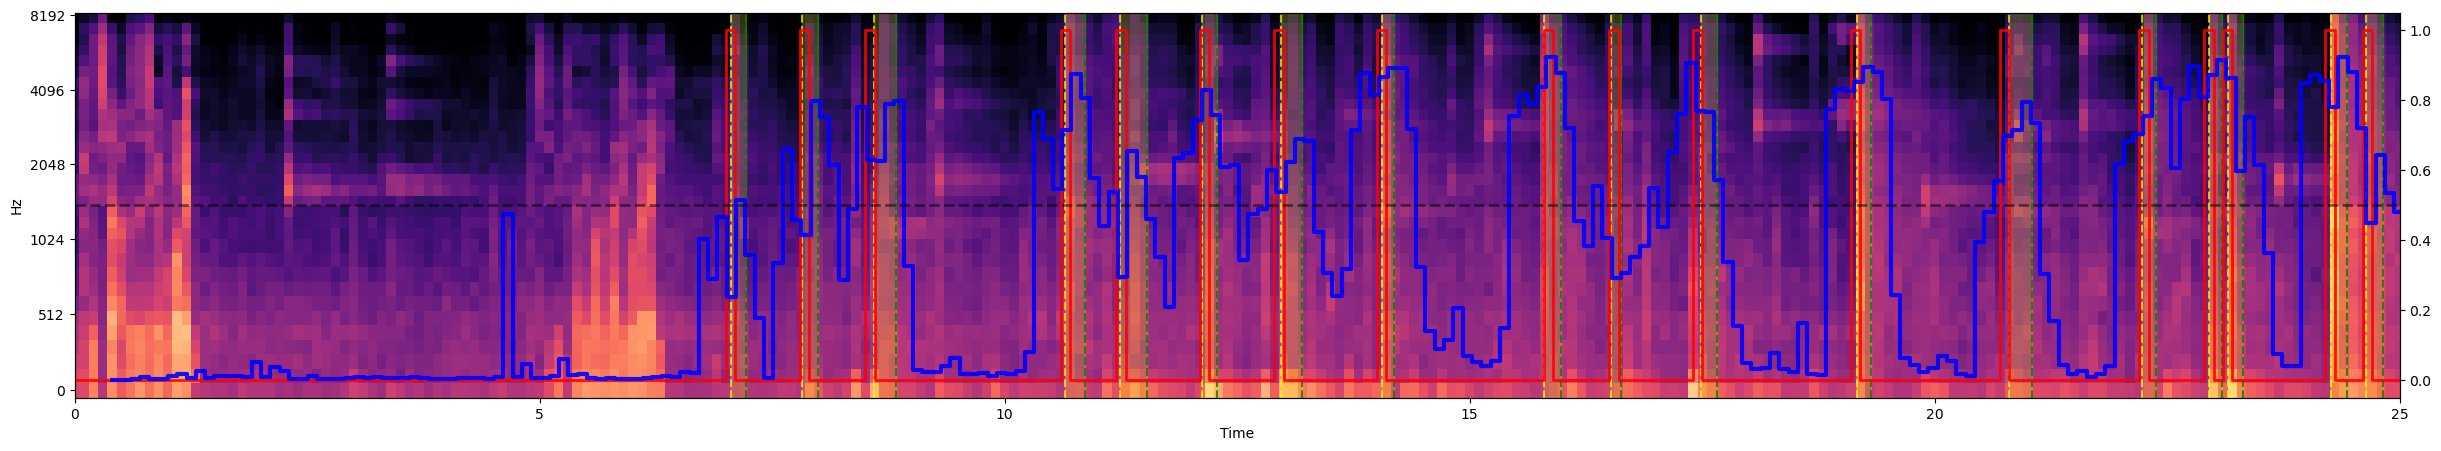

In [541]:

def predict_spectrogram(model, spec):
    
    wins = compute_windows(spec, frames=window_length, step=1)
    t = numpy.linspace(0.0, (spec.shape[1]/window_length)*window_duration, len(wins))
    X = numpy.expand_dims(numpy.stack( [ w-Xm for w in wins ]), -1)
    
    y = numpy.squeeze(model.predict(X))
    
    # TODO: merge the overlapping windows with eachother
    y = numpy.max(y, axis=1)# .shape

    # shift predictions to middle of window
    t += (window_duration*0.5)
    
    t = pandas.to_timedelta(t, unit='s')
    
    print(t.shape, y.shape, len(wins), print(t[-1]))
    
    df = pandas.DataFrame({
        'time': t,
        'probability': y,
    })
    return df
    
predictions = predict_spectrogram(model, spec)
fig, ax = plt.subplots(1, figsize=(30, 5))
plot_spectrogram(ax, spec, annotations, l, predictions)
ax.set_xlim(0, 25)



(40.0, 60.0)

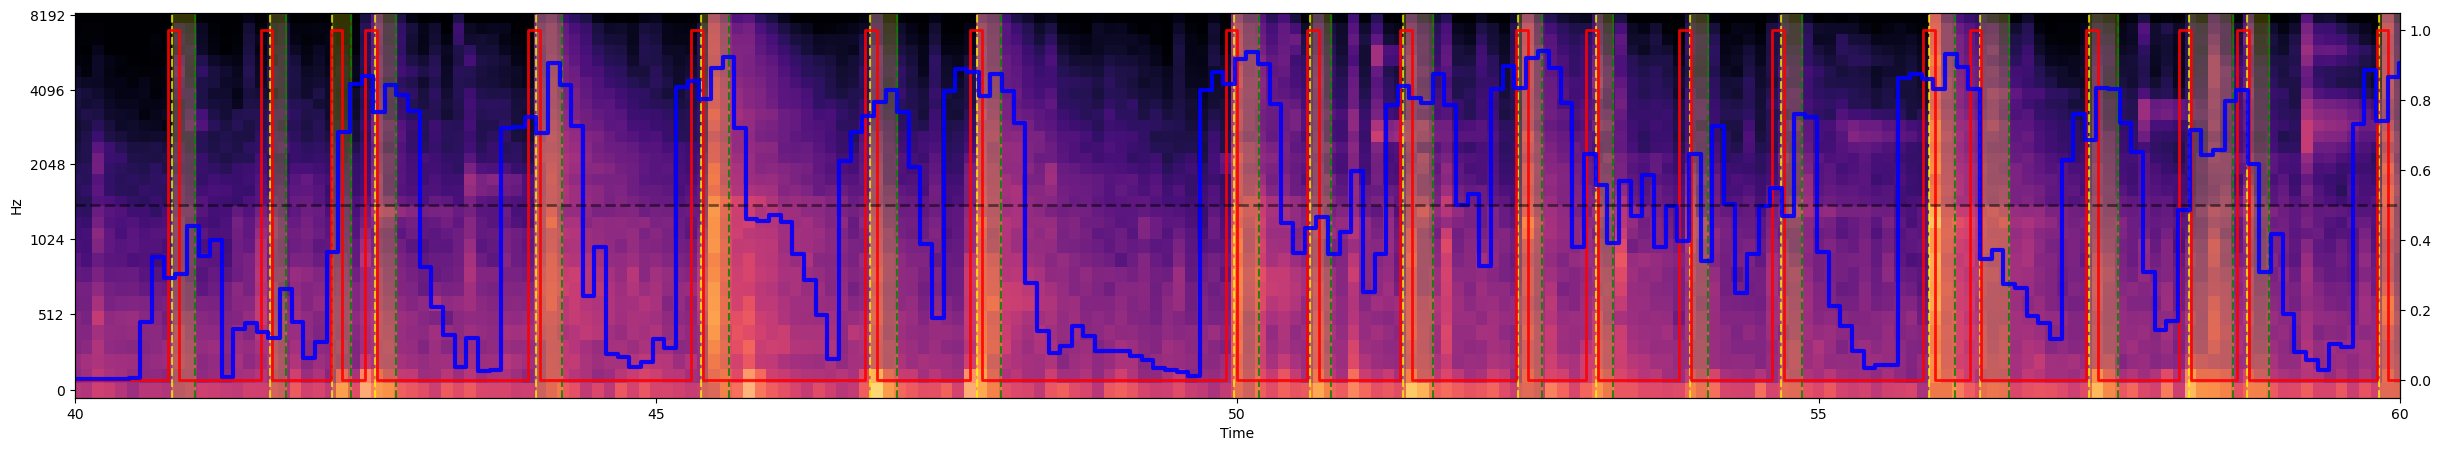

In [542]:
fig, ax = plt.subplots(1, figsize=(30, 5))
plot_spectrogram(ax, spec, annotations, l, predictions)
ax.set_xlim(40, 60)

In [ ]:
# TODO: add event-based evaluation

In [ ]:
# 